In [1]:
%env CUDA_VISIBLE_DEVICES=2
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from math import floor

import sys
# sys.path.append('../csgm-robust-neurips/pytorch_GAN_zoo/')
sys.path.append('./pytorch_GAN_zoo/')
import hubconf

env: CUDA_VISIBLE_DEVICES=2


# define the generator and hyperparameters

Average network found !


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


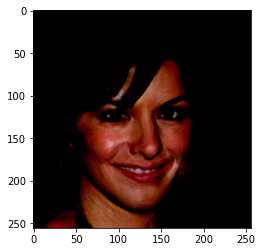

In [2]:
device = 'cuda:0'
kwargs = {'model_name': 'celebAHQ-256',
          'useGPU': True}

model = hubconf.PGAN(pretrained = True, **kwargs)

# inputRandom, randomLabels = model.buildNoiseData(1)

# inputRandom.shape
nz = 512
n = 3*256*256

z0 = torch.randn(1,nz).to(device)
z0.requires_grad = False

x0 = model.test(z0, getAvG=True, toCPU=False)

plt.imshow(x0.detach().cpu().numpy()[0].transpose(1,2,0))

In [3]:
# make a wrapper for generating from z
def gen(z_var):
    return model.test(z_var, getAvG=True, toCPU=False)

# ERM on good samples

In [10]:
m = 1000
n = 3* 256 * 256
n_features = n

A = torch.randn(m, n).to(device) / np.sqrt(m)
y = torch.mm(A, x0.view(-1,1))

In [14]:
z = torch.randn(1, nz)
z.requires_grad = True

niter = 1500
loss_val = torch.zeros(niter)
mse = torch.nn.MSELoss(reduction='sum')

opt = torch.optim.Adam([z], lr=1e-2)
for i in range(niter):
    opt.zero_grad()
    x = gen(z)
    loss = mse(torch.mm(A, x.view(-1,1)), y)
    loss.backward()
    
    if (i+1) % 10 == 0:
        print('i: %d loss: %f'%(i,loss.item()))
    loss_val[i] = loss.item()
    
    opt.step()
    

i: 9 loss: 39463.937500
i: 19 loss: 22951.544922
i: 29 loss: 20883.353516
i: 39 loss: 17496.972656
i: 49 loss: 16000.115234
i: 59 loss: 14399.106445
i: 69 loss: 13742.500000
i: 79 loss: 13217.468750
i: 89 loss: 12821.610352
i: 99 loss: 12507.911133
i: 109 loss: 12125.508789
i: 119 loss: 11753.916016
i: 129 loss: 11363.296875
i: 139 loss: 10793.558594
i: 149 loss: 10094.801758
i: 159 loss: 8895.783203
i: 169 loss: 8294.935547
i: 179 loss: 7919.030762
i: 189 loss: 7651.233887
i: 199 loss: 7348.027344
i: 209 loss: 7097.660156
i: 219 loss: 6890.409180
i: 229 loss: 6724.305664
i: 239 loss: 6545.375488
i: 249 loss: 6363.155762
i: 259 loss: 6207.761719
i: 269 loss: 6039.841309
i: 279 loss: 5810.233398
i: 289 loss: 5623.965332
i: 299 loss: 5517.206543
i: 309 loss: 5442.214844
i: 319 loss: 5348.905762
i: 329 loss: 5253.018066
i: 339 loss: 5177.046875
i: 349 loss: 5101.530273
i: 359 loss: 5019.104492
i: 369 loss: 4941.842773
i: 379 loss: 4878.645508
i: 389 loss: 4824.057617
i: 399 loss: 4773.159

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


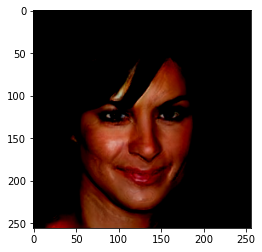

In [15]:
plt.imshow(x.detach().cpu().numpy()[0].transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


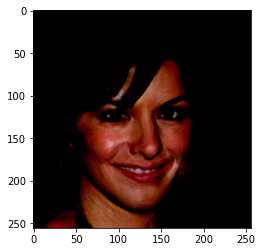

In [16]:
plt.imshow(x0.detach().cpu().numpy()[0].transpose(1,2,0))

# create noisy data 

In [5]:
def data1(n_samples, x , sigma):
    n_features = x.view(-1).size()[0]
    A = torch.randn([n_samples, n_features], device=device)/np.sqrt(n_samples)
    y = A.mm(x.view(-1,1)) + sigma * torch.randn([n_samples,1], device=device)
    return y, A

def data2(n_outliers, n_features, type_outliers = 1, beta = 1, rho=1):
    if type_outliers == 1:
        Y = np.ones(n_outliers)
        X = np.ones((n_outliers, n_features))
    elif type_outliers == 2:
        Y = 10000*torch.ones([n_outliers,1], device=device)#100*torch.ones([n_outliers,1], device=device)
        X = torch.ones([n_outliers, n_features], device=device)
    elif type_outliers == 3:
        Y = np.random.randint(2, size = n_outliers)
        X = np.random.rand(n_outliers, n_features)
    else:
        cov = np.identity(n_features)
        X = feature_mat(n_features, n_outliers, rho)
        Y = X.dot(beta) + sigma * randn(n_samples)
    return Y, X
        
def data3(n_heavy_tail, x, deg = 2):
    n_features = x.view(-1).size()[0]
    A = torch.Tensor(np.random.standard_t(2, size=(n_heavy_tail,n_features))).to(device)/np.sqrt(n_features)#(torch.randn([n_heavy_tail, n_features], device=device)**2)/np.sqrt(n_heavy_tail) 
    y = A.mm(x.view(-1,1)) + torch.Tensor(np.random.standard_t(deg, size=(n_heavy_tail,1))).to(device)
    return y, A

def data_merge(y1, A1, y2, A2):
    y = torch.cat((y1, y2))
    A = torch.cat((A1, A2))
    return y, A

def log_normal_data(n_samples, x, sigma):
    n_features = x.view(-1,1).size()[0]
    A = torch.randn(n_samples, n_features)
    A = torch.exp(A)
    y = A.mm(x.view(-1,1)) + sigma*torch.exp(torch.randn(n_samples,1))
    return y, A

In [6]:
m_good = 980
m_bad = 20
sigma = 1e-2


In [7]:
y_good, A_good = data1(m_good, x0, sigma)
y_bad, A_bad = data2(m_bad, n_features, 2)#data3(m_bad, x, noise_degree)
y, A = data_merge(y_good, A_good, y_bad, A_bad)


# MOM estimate

i: 9 loss: 0.199974
i: 19 loss: 0.185807
i: 29 loss: 0.167406
i: 39 loss: 0.144817
i: 49 loss: 0.132346
i: 59 loss: 0.130156
i: 69 loss: 0.127230
i: 79 loss: 0.124487
i: 89 loss: 0.119503
i: 99 loss: 0.114156
i: 109 loss: 0.111403
i: 119 loss: 0.103942
i: 129 loss: 0.096636
i: 139 loss: 0.084797
i: 149 loss: 0.078167
i: 159 loss: 0.069259
i: 169 loss: 0.062091
i: 179 loss: 0.057549
i: 189 loss: 0.052801
i: 199 loss: 0.053452
i: 209 loss: 0.049429
i: 219 loss: 0.047327
i: 229 loss: 0.046090
i: 239 loss: 0.045803
i: 249 loss: 0.045352
i: 259 loss: 0.044646
i: 269 loss: 0.044493
i: 279 loss: 0.046459
i: 289 loss: 0.044728
i: 299 loss: 0.039897
i: 309 loss: 0.036691
i: 319 loss: 0.035983
i: 329 loss: 0.034904
i: 339 loss: 0.035124
i: 349 loss: 0.032717
i: 359 loss: 0.031710
i: 369 loss: 0.030732
i: 379 loss: 0.030081
i: 389 loss: 0.030201
i: 399 loss: 0.029956
i: 409 loss: 0.029337
i: 419 loss: 0.027867
i: 429 loss: 0.026474
i: 439 loss: 0.026443
i: 449 loss: 0.025753
i: 459 loss: 0.025676

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'number of iterations')

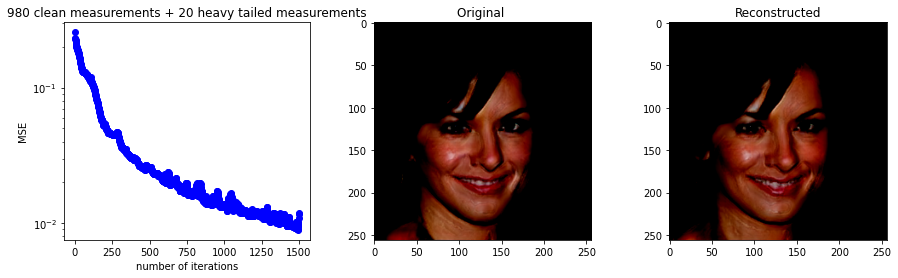

In [8]:
# variable for f
zf = torch.randn(z0.shape, device=device)
zf.requires_grad = True

# variable for g
zg = torch.randn(z0.shape, device=device)
zg.requires_grad = True

# learning rate, number of iterations and batch_size
LRF = 1e-2
LRG = 1e-2
N_ITER = 1500
batch_size = 20

# array for storing error values
loss_mom = torch.zeros(N_ITER)

# DO NOT REDUCE(via mean or sum) the square error terms
# the corrupted samples become mixed with the
# clean samples
se_unreduced = nn.MSELoss(reduction='none')

# adam optimizers
opt_f = torch.optim.Adam([zf], lr=LRF)
opt_g = torch.optim.Adam([zg], lr=LRG)


def mom_obj(A, y, zf, zg, batch_size):
    shuffled_idx = torch.randperm(A.size()[0])
    A_shuffled = A.clone()[shuffled_idx, :]
    y_shuffled = y.clone().view(-1)[shuffled_idx].view(y.size())
    
    # compute AG(zf), AG(zg)
    Af = A_shuffled.mm(gen(zf).view(-1,1))
    Ag = A_shuffled.mm(gen(zg).view(-1,1))
    
    # find (y_i - a_iG(zf))^2 , (y_i - a_iG(zg))^2 
    loss_1 = se_unreduced(Af, y_shuffled)
    loss_2 = se_unreduced(Ag, y_shuffled)

    # now find median block of loss_1 - loss_2
    loss_3 = loss_1 - loss_2
    loss_3 = loss_3[:batch_size*(A.shape[0]//batch_size)] # make the number of rows a multiple of batch size
    loss_3 = loss_3.view(-1,batch_size) # reshape
    loss_3 = loss_3.mean(axis=1) # find mean on each batch
    loss_3_numpy = loss_3.detach().cpu().numpy() # convert to numpy

    median_idx = np.argsort(loss_3_numpy)[loss_3_numpy.shape[0]//2] # sort and pick middle element

    # pick median block
    loss_1_mom = loss_1[median_idx*batch_size : batch_size*(median_idx+1),:]
    loss_2_mom = loss_2[median_idx*batch_size : batch_size*(median_idx+1),:]
    loss_f = torch.mean(loss_1_mom - loss_2_mom)
    
    return loss_f
    
for i in range(N_ITER):
    # take descen step in zf
    opt_f.zero_grad()
    loss_f = mom_obj(A, y, zf, zg, batch_size)
    loss_f.backward()
    opt_f.step()  

    # take ascent step in zg
    opt_g.zero_grad()
    loss_g = -1 * mom_obj(A, y, zf, zg, batch_size)
    loss_g.backward()
    opt_g.step()    

    # record error value
    loss_mom[i] = torch.norm(gen(zf).detach()-x0)**2/n_features
    
    if (i+1) % 10 == 0:
        print('i: %d loss: %f'%(i,loss_mom[i].item()))
    
fig,ax = plt.subplots(1,3, figsize=(15,4))
ax[0].semilogy(range(1,N_ITER+1),loss_mom.detach(),'bo-')

ax[1].imshow(x0[0].cpu().numpy().transpose(1,2,0))
ax[2].imshow(gen(zf)[0].detach().cpu().numpy().transpose(1,2,0))
ax[0].set_title('%d clean measurements + %d heavy tailed measurements'%(m_good, m_bad))
ax[1].set_title('Original ')
ax[2].set_title('Reconstructed')
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('number of iterations')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


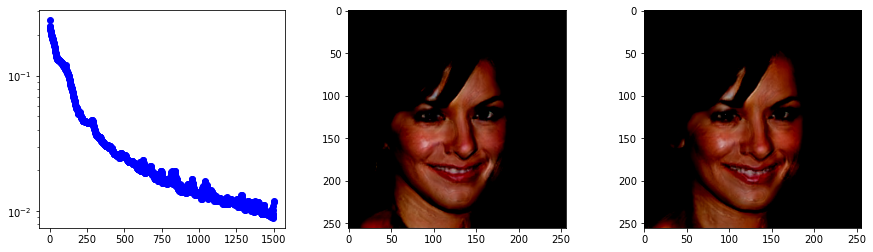

In [9]:
fig,ax = plt.subplots(1,3, figsize=(15,4))
ax[0].semilogy(range(1,N_ITER+1),loss_mom.detach(),'bo-')

ax[1].imshow(x0[0].cpu().numpy().transpose(1,2,0),cmap='gray')
ax[2].imshow(gen(zf)[0].detach().cpu().numpy().transpose(1,2,0),cmap='gray')